<a href="https://colab.research.google.com/github/dinhluan14/Classification-of-social-media-text-in-Vietnamese/blob/main/LSTM_UIT_VSMEC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Dowload dataset**

In [ ]:
# valid
!gdown --id 1ch_F1fRqgBuT5bLLk6CbJoHO1TpvEEnQ 
# train
!gdown --id 1svJAKgX2W6CzLk5wWt4A5oKnn25yNha9
# test
!gdown --id 1IqxO0hhfVyNbDWkbbwyuz9NGM6G_md_R

Downloading...
From: https://drive.google.com/uc?id=1ch_F1fRqgBuT5bLLk6CbJoHO1TpvEEnQ
To: /content/valid_nor_811.xlsx
100% 38.0k/38.0k [00:00<00:00, 4.85MB/s]
Downloading...
From: https://drive.google.com/uc?id=1svJAKgX2W6CzLk5wWt4A5oKnn25yNha9
To: /content/train_nor_811.xlsx
100% 259k/259k [00:00<00:00, 38.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1IqxO0hhfVyNbDWkbbwyuz9NGM6G_md_R
To: /content/test_nor_811.xlsx
100% 37.6k/37.6k [00:00<00:00, 32.8MB/s]


In [ ]:
# Import
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import scatter_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import  train_test_split
from sklearn.metrics import mean_squared_log_error
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

import keras
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils
from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


#Load Dataset


## Train set

In [ ]:
df_train = pd.read_excel("/content/train_nor_811.xlsx",index_col = None,usecols = "B,C:AA").reindex(columns=["Sentence","Emotion"])
df_train

,Sentence,Emotion
0,cho mình xin bài nhạc tên là gì với ạ,Other
1,cho đáng đời con quỷ . về nhà lôi con nhà mày ...,Disgust
2,lo học đi . yêu đương lol gì hay lại thích học...,Disgust
3,uớc gì sau này về già vẫn có thể như cụ này :)),Enjoyment
4,mỗi lần có video của con là cứ coi đi coi lại ...,Enjoyment
...,...,...
5543,đường của nhà cụ hay sao mà cụ cấm người ta đỗ...,Disgust
5544,nhìn mặt héo queo luôn,Other
5545,tao đi xe máy mỗi lần muốn để xe đi đâu là phi...,Other
5546,thích thân hình boss rồi nhan 😌,Enjoyment


## Test set


In [ ]:
df_test = pd.read_excel("/content/test_nor_811.xlsx",index_col = None,usecols = "B,C:AA").reindex(columns=["Sentence","Emotion"])
df_test

,Sentence,Emotion
0,người ta có bạn bè nhìn vui thật,Sadness
1,cho nghỉ viêc mói đúng sao goi là kỷ luật,Surprise
2,kinh vãi 😡,Disgust
3,nhà thì không xa lắm nhưng chưa bao giờ đi vì ...,Fear
4,bố không thích nộp đấy mày thích ý kiến không,Anger
...,...,...
688,lúc thì cuốc đất è cổ ra không có giun mà câu ...,Sadness
689,các bác dẫn crush qua cây sữa nay mà hứng nước...,Enjoyment
690,vợ chồng rồi mà trong sáng như này chỉ có tron...,Surprise
691,bep này vào binh dương dùng xuất,Other


##Valid set

In [ ]:
df_valid = pd.read_excel("/content/valid_nor_811.xlsx",index_col = None,usecols = "B,C:AA").reindex(columns=["Sentence","Emotion"])
df_valid

,Sentence,Emotion
0,"tính tao tao biết , chẳng có chuyện gì có thể ...",Other
1,"lại là lào cai , tự hào quê mình quá :))",Enjoyment
2,bị từ chối rồi,Sadness
3,tam đảo trời đẹp các mem à,Enjoyment
4,đọc bình luận của thằng đó không thiếu chữ nào 😂😂,Other
...,...,...
681,nhọc lòng :(((,Sadness
682,tao đã rất muốn làm bạn tốt anh em tri kỉ với ...,Sadness
683,cơm tấm ở ngoài cũng như này . 😡,Disgust
684,chất liệu đỉnh quá,Surprise


# DATA PREPARATION

In [ ]:
import re
df_train = df_train.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
# BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
# STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    # text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('.', '')
#    text = re.sub(r'\W+', '', text)
    # text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
# df['Consumer complaint narrative'] = df['Consumer complaint narrative'].apply(clean_text)
df_train["Sentence"] = df_train["Sentence"].apply(clean_text)
df_test["Sentence"] = df_test["Sentence"].apply(clean_text)
df_valid["Sentence"] = df_valid["Sentence"].apply(clean_text)

In [ ]:
df_train["Emotion"].value_counts()

Enjoyment    1558
Disgust      1071
Other        1021
Sadness       947
Anger         391
Fear          318
Surprise      242
Name: Emotion, dtype: int64

#Pre-training

In [ ]:
Emotion_train = pd.get_dummies(df_train['Emotion']).values
print('Shape of label train tensor:', Emotion_train.shape)
Emotion_valid = pd.get_dummies(df_valid['Emotion']).values
print('Shape of label dev tensor:', Emotion_valid.shape)
Emotion_test = pd.get_dummies(df_test['Emotion']).values
print('Shape of label test tensor:', Emotion_test.shape)

Shape of label train tensor: (5548, 7)
Shape of label dev tensor: (686, 7)
Shape of label test tensor: (693, 7)


In [ ]:
Sentence_test = df_test['Sentence']
Sentence_test = np.array(Sentence_test)
# Sentence_test
Sentence_valid = df_valid['Sentence']
Sentence_valid = np.array(Sentence_valid)
# Sentence_valid.shape
Sentence_train = df_train['Sentence']
Sentence_train = np.array(Sentence_train)
Sentence_train

array(['cho mình xin bài nhạc tên là gì với ạ',
       'cho đáng đời con quỷ  về nhà lôi con nhà mày ra mà đánh 😡',
       'lo học đi  yêu đương lol gì hay lại thích học sinh học', ...,
       'tao đi xe máy mỗi lần muốn để xe đi đâu là phi mẹ nó vào quán net gửi đấy rồi đi ra đéo mất phí',
       'thích thân hình boss rồi nhan 😌',
       'ước mơ nhỏ nhoi của tao là được làm chị mà không thể nào làm được huhu'],
      dtype=object)

In [ ]:
vocab_size = 10000
embedding_dim = 64 # chieu cua embedding
max_length = 100

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer  # thư viện tách từ
from tensorflow.keras.preprocessing.sequence import pad_sequences # 
# tokenize các câu văn sang chuỗi index và padding câu văn về cũng một độ dài.
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(Sentence_train)

Sentence_train_sequences = tokenizer.texts_to_sequences(Sentence_train)
padded_Sentence_train_sequences = pad_sequences(Sentence_train_sequences, maxlen=max_length, truncating='post', padding='post')
padded_Sentence_train_sequences.shape

(5548, 100)

In [ ]:
Sentence_valid_sequences = tokenizer.texts_to_sequences(Sentence_valid)
padded_Sentence_valid_sequences = pad_sequences(Sentence_valid_sequences, maxlen=max_length, truncating='post', padding='post')
padded_Sentence_valid_sequences.shape

(686, 100)

In [ ]:
Sentence_test_sequences = tokenizer.texts_to_sequences(Sentence_test)
padded_Sentence_test_sequences = pad_sequences(Sentence_test_sequences, maxlen=max_length, truncating='post', padding='post')
padded_Sentence_test_sequences.shape

(693, 100)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM,SpatialDropout1D, Dense, Flatten,Dropout

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 64)           640000    
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 100, 64)           0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 128)               66048     
_________________________________________________________________
flatten_5 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 7)                

In [ ]:
model.fit(padded_Sentence_train_sequences, Emotion_train, epochs=10, batch_size=32,validation_data=(padded_Sentence_valid_sequences, Emotion_valid))

Epoch 1/10
174/174 [==============================] - 26s 122ms/step - loss: 1.7712 - accuracy: 0.2902 - val_loss: 1.6480 - val_accuracy: 0.3703
Epoch 2/10
174/174 [==============================] - 20s 116ms/step - loss: 1.4573 - accuracy: 0.4558 - val_loss: 1.4882 - val_accuracy: 0.4490
Epoch 3/10
174/174 [==============================] - 20s 116ms/step - loss: 1.1777 - accuracy: 0.5633 - val_loss: 1.3852 - val_accuracy: 0.4810
Epoch 4/10
174/174 [==============================] - 20s 116ms/step - loss: 1.0220 - accuracy: 0.6298 - val_loss: 1.3900 - val_accuracy: 0.4752
Epoch 5/10
174/174 [==============================] - 20s 115ms/step - loss: 0.8929 - accuracy: 0.6757 - val_loss: 1.4030 - val_accuracy: 0.5029
Epoch 6/10
174/174 [==============================] - 20s 116ms/step - loss: 0.7834 - accuracy: 0.7282 - val_loss: 1.4756 - val_accuracy: 0.5190
Epoch 7/10
174/174 [==============================] - 20s 116ms/step - loss: 0.7138 - accuracy: 0.7529 - val_loss: 1.5871 - val_ac

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM,SpatialDropout1D, Dense

model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model1.add(SpatialDropout1D(0.2))
model1.add(Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0)))
model1.add(Dense(7, activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.summary()

In [ ]:
model1.fit(padded_Sentence_train_sequences, Emotion_train, epochs=10, batch_size=32,validation_data=(padded_Sentence_valid_sequences, Emotion_valid))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/LSTM

/content/drive/MyDrive/LSTM


In [ ]:
model.save("LSTM.h5")

In [ ]:
model1.save("LSTM1.h5")

In [ ]:
sents_pred = model.predict(padded_Sentence_test_sequences)
sents_pred.shape

(693, 7)

In [ ]:
sents_pred = (sents_pred > 0.5)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

accuracy_score(Emotion_test,sents_pred )

0.4675324675324675

In [ ]:
print(classification_report(Emotion_test,sents_pred))
print("Accuracy: \t",accuracy_score(Emotion_test,sents_pred))
print("F1-Score: \t",f1_score(Emotion_test,sents_pred, average="macro"))
print("Precision: \t",precision_score(Emotion_test,sents_pred, average="macro"))
print("Recall: \t",recall_score(Emotion_test,sents_pred, average="macro"))

              precision    recall  f1-score   support

           0       0.50      0.25      0.33        40
           1       0.56      0.48      0.52       132
           2       0.61      0.60      0.60       193
           3       0.68      0.57      0.62        46
           4       0.35      0.37      0.36       129
           5       0.69      0.45      0.54       116
           6       0.56      0.24      0.34        37

   micro avg       0.55      0.47      0.51       693
   macro avg       0.57      0.42      0.47       693
weighted avg       0.56      0.47      0.50       693
 samples avg       0.47      0.47      0.47       693

Accuracy: 	 0.4675324675324675
F1-Score: 	 0.47468144379561095
Precision: 	 0.5665843817930308
Recall: 	 0.42279041814294965


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix

cm_nb = confusion_matrix(Emotion_test.argmax(axis=1),sents_pred.argmax(axis=1))
cm_nb

array([[ 21,  11,   0,   3,   2,   3,   0],
       [ 31,  68,  13,   2,   9,   8,   1],
       [ 29,  12, 106,   3,  27,  15,   1],
       [  9,   4,   6,  24,   2,   1,   0],
       [ 29,  22,  22,   1,  37,  17,   1],
       [ 15,  11,  13,   0,   9,  68,   0],
       [  9,   6,   6,   0,   4,   2,  10]])

In [ ]:
set(df_train['Emotion'])

{'Anger', 'Disgust', 'Enjoyment', 'Fear', 'Other', 'Sadness', 'Surprise'}

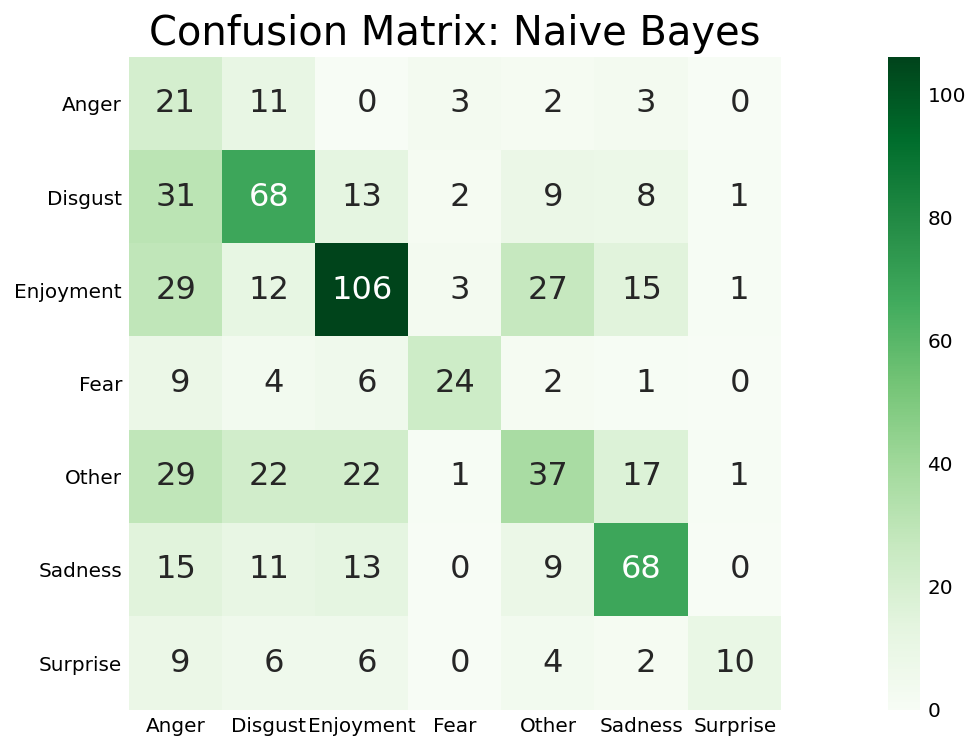

In [ ]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
y_train = le.fit_transform(df_train["Emotion"])

plt.figure(figsize=(17,6))
plt.title('Confusion Matrix: Naive Bayes', fontsize=20)
cm_nb = confusion_matrix(Emotion_test.argmax(axis=1),sents_pred.argmax(axis=1))
# df_cm_nb = pd.DataFrame(cm_nb, index=np.unique(le.inverse_transform(y_train)), columns=np.unique(le.inverse_transform(sents_pred)))
df_cm_nb = pd.DataFrame(cm_nb, index=['Anger', 'Disgust', 'Enjoyment', 'Fear', 'Other', 'Sadness', 'Surprise'], columns=['Anger', 'Disgust', 'Enjoyment', 'Fear', 'Other', 'Sadness', 'Surprise'])
sns.heatmap(df_cm_nb, annot=True, square=True, annot_kws={"size": 16}, fmt='2g', cmap='Greens')
